In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2-4*x+5

In [3]:
f(3.0)

20.0

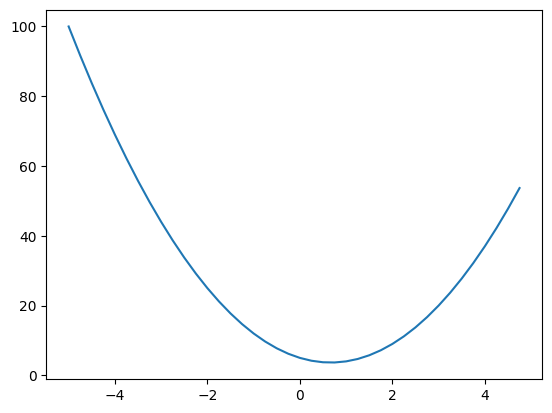

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.000001
x = 2/3
(f(x+h) -f(x))/h

2.999378523327323e-06

In [6]:
#let's get more complex (ok karpathy)

a = 2.0
b = -3
c = 10

d = a*b+c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3
c = 10

d1 = a*b+c
c += h
d2 = a*b+c
print('d1,',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1, 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
    def __init__(self,data, _children = (), _op ='', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f'Value(data={self.data})'
    

    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    

    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out

        

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'

d = e + c; d.label = 'd'
f = Value(-2.0, label ='f')
L = d*f; L.label = 'L'



In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{ %s |data %.4f | grad%.4f}' % (n.label,n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

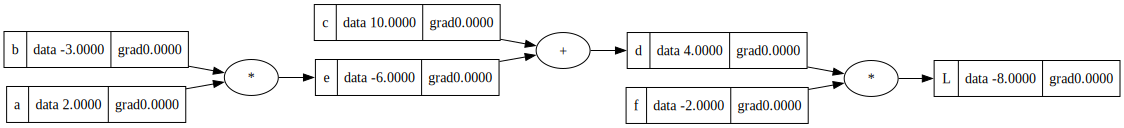

In [10]:
draw_dot(L)

In [11]:
#dd/dc? 1.0
#dd/de? 1.0

#d = c + e

#Chain rule!
#we want:
#dL/dc
#we know:
#dL/dd = -2.0
#dd/dc = 1.0

#chain rule states (dL/dd) * (dd/dc) = dL/dc

#lets apply chain rule again to get dL / da and dL / db
#we know that:
#dL/de = -2.0
#chain rule says that dL / da = (dL / de) * local gradient.
#dL / da = (dL / de) * (de/da) 

#e = a*b, 
#de/da = b
#de/db = a
#so dL/da = (dL/de) * b
#and dL/db = (dL/de) * a

In [12]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'

L.grad = 1.0
f.grad = 4.0
d.grad = -2
c.grad = -2.0 * 1.0
e.grad = -2.0 * 1.0
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a*b
d = e+c
L = d*f

L.data


-7.4352

In [13]:
def numerical_derivator():
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label ='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    b.data += h
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label ='f')
    L = d*f; L.label = 'L'
    L2 = L.data 
    
    print((L2-L1)/h)

numerical_derivator()

-4.000000000008441


### Backpropagation is just recursively going through every node of a NN and locally applying the chain rule to figure out how each node affects the final output node


#### Manual Backpropagation example 2: A neuron

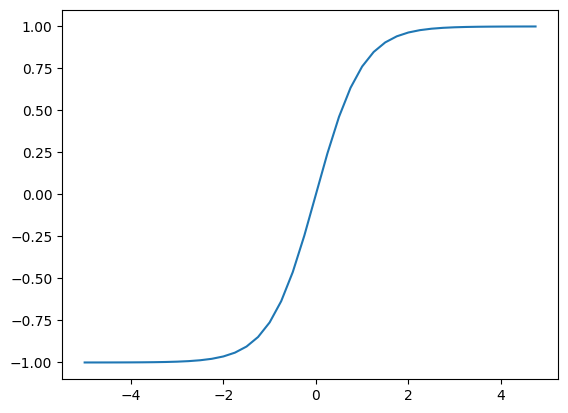

In [14]:
plt.plot( np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25)))

In [15]:
#inputs x1,x2
x1 = Value(2.0, label = 'x1')

x2 = Value(0.0, label = 'x2')
#weights w1, w2
w1 = Value(-3.0, label = 'w1')

w2 = Value(1.0, label = 'w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

#x1w1 + x2w2 + b 
x1w1 = x1*w1; x1w1.label='x1*w1'

x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'


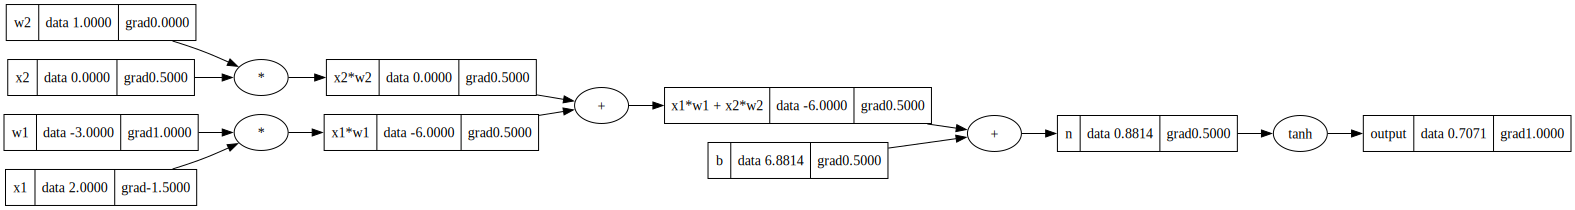

In [19]:
draw_dot(o)


In [17]:
o.grad = 1.0
n.grad = 1 - o.data **2 #0.5
x1w1x2w2.grad = 0.5 #backpropagation distributes previous gradient through + operator. derivatives of both of these are 1 and chain rule thus causes us to multiply previous local derivative by 1
b.grad = 0.5 #same as x1w1x2w2 grad definition


#Now time to do the same for x2w2 and x1w1 nerons as well, as they are also combined by an addition operator in the math expression. same logic as before
x2w2.grad = 0.5
x1w1.grad = 0.5
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

In [18]:
# o = tanh(n)
# do/dn = 1-(tanh(n))**2
# do/dn = 1-o**2